# LSTM Sequence Feature Extraction

Extract temporal patterns from customer transaction sequences using LSTM.
The LSTM embeddings will be added as features for tree models.

**Architecture:**
- Sequence length: 10 transactions
- Hidden size: 64
- Embedding dimension: 64
- Bidirectional LSTM with Focal Loss

In [1]:
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## 1. Load Data

In [2]:
# load raw data
df = pd.read_csv('../data/raw/nibss_fraud_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['customer_id', 'timestamp']).reset_index(drop=True)

print(f"Loaded {len(df):,} transactions")
print(f"Fraud rate: {df['is_fraud'].mean()*100:.3f}%")

# load processed data
with open('../data/processed_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

feature_names = processed_data['feature_names']
print(f"Original features: {len(feature_names)}")

Loaded 1,000,000 transactions
Fraud rate: 0.300%
Original features: 61


## 2. Prepare LSTM Features

In [3]:
# select features for LSTM
lstm_features = [
    'amount', 'hour', 'day_of_week', 'month',
    'tx_count_24h', 'amount_sum_24h', 'amount_mean_7d', 'amount_std_7d',
    'tx_count_total', 'amount_mean_total', 'amount_std_total',
    'channel_diversity', 'location_diversity',
    'amount_vs_mean_ratio', 'hour_sin', 'hour_cos',
    'amount_log', 'velocity_score'
]

lstm_features = [f for f in lstm_features if f in df.columns]
print(f"LSTM input features: {len(lstm_features)}")

# scale
scaler = RobustScaler()
df[lstm_features] = df[lstm_features].fillna(0)
df[lstm_features] = scaler.fit_transform(df[lstm_features])
df[lstm_features] = df[lstm_features].clip(-10, 10)

# time-based split
df = df.sort_values('timestamp').reset_index(drop=True)
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"Train: {len(train_df):,}")
print(f"Test: {len(test_df):,}")

LSTM input features: 18
Train: 800,000
Test: 200,000


## 3. Sequence Dataset

In [4]:
SEQ_LEN = 10

class TransactionSequenceDataset(Dataset):
    def __init__(self, df, feature_cols, seq_len=10):
        self.seq_len = seq_len
        self.sequences = []
        self.labels = []
        self.indices = []

        for customer_id, group in df.groupby('customer_id'):
            group = group.sort_values('timestamp').reset_index(drop=True)
            features = group[feature_cols].values
            labels = group['is_fraud'].values
            original_indices = group.index.values

            for i in range(len(group)):
                if i < seq_len - 1:
                    seq = np.zeros((seq_len, len(feature_cols)))
                    seq[-(i+1):] = features[:i+1]
                else:
                    seq = features[i-seq_len+1:i+1]

                self.sequences.append(seq)
                self.labels.append(labels[i])
                self.indices.append(original_indices[i])

        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.float32)
        self.indices = np.array(self.indices)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.FloatTensor(self.sequences[idx]),
            torch.FloatTensor([self.labels[idx]]),
            self.indices[idx]
        )

print("Creating sequence datasets...")
train_dataset = TransactionSequenceDataset(train_df, lstm_features, SEQ_LEN)
test_dataset = TransactionSequenceDataset(test_df, lstm_features, SEQ_LEN)

print(f"Train sequences: {len(train_dataset):,}")
print(f"Test sequences: {len(test_dataset):,}")

Creating sequence datasets...
Train sequences: 800,000
Test sequences: 200,000


## 4. Weighted Sampling

In [5]:
class_counts = np.bincount(train_dataset.labels.astype(int))
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_dataset.labels.astype(int)]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 3125
Test batches: 782


## 5. LSTM Model

In [6]:
class FraudLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3, embedding_dim=64):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        self.embedding_layer = nn.Sequential(
            nn.Linear(hidden_size * 2, embedding_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x, return_embedding=False):
        lstm_out, (h_n, c_n) = self.lstm(x)
        hidden = torch.cat([h_n[-2], h_n[-1]], dim=1)
        embedding = self.embedding_layer(hidden)
        logits = self.classifier(embedding)

        if return_embedding:
            return logits, embedding
        return logits


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce)
        focal_weight = self.alpha * (1 - pt) ** self.gamma
        return (focal_weight * bce).mean()

In [7]:
INPUT_SIZE = len(lstm_features)
HIDDEN_SIZE = 64
EMBEDDING_DIM = 64
NUM_EPOCHS = 20
LR = 0.001

model = FraudLSTM(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM
).to(device)

criterion = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 152,705


## 6. Train LSTM

In [8]:
best_auc = 0
train_losses = []
val_aucs = []

print("Training LSTM...")
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y, _ in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        if torch.isnan(loss):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y, _ in test_loader:
            batch_x = batch_x.to(device)
            outputs = torch.sigmoid(model(batch_x))
            all_probs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(batch_y.numpy().flatten())

    auc = roc_auc_score(all_labels, all_probs)
    val_aucs.append(auc)
    scheduler.step(-auc)

    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), '../models/lstm.pt')

    print(f"Epoch {epoch+1:2d}: Loss={train_losses[-1]:.4f}, AUC={auc:.4f}")

print(f"\nBest AUC: {best_auc:.4f}")

Training LSTM...
Epoch  1: Loss=0.0056, AUC=0.9793
Epoch  2: Loss=0.0008, AUC=0.9882
Epoch  3: Loss=0.0005, AUC=0.9850
Epoch  4: Loss=0.0003, AUC=0.9872
Epoch  5: Loss=0.0003, AUC=0.9885
Epoch  6: Loss=0.0002, AUC=0.9866
Epoch  7: Loss=0.0002, AUC=0.9899
Epoch  8: Loss=0.0002, AUC=0.9840
Epoch  9: Loss=0.0002, AUC=0.9874
Epoch 10: Loss=0.0001, AUC=0.9897
Epoch 11: Loss=0.0001, AUC=0.9898
Epoch 12: Loss=0.0000, AUC=0.9884
Epoch 13: Loss=0.0000, AUC=0.9892
Epoch 14: Loss=0.0000, AUC=0.9913
Epoch 15: Loss=0.0000, AUC=0.9878
Epoch 16: Loss=0.0000, AUC=0.9885
Epoch 17: Loss=0.0000, AUC=0.9889
Epoch 18: Loss=0.0000, AUC=0.9846
Epoch 19: Loss=0.0000, AUC=0.9857
Epoch 20: Loss=0.0000, AUC=0.9883

Best AUC: 0.9913


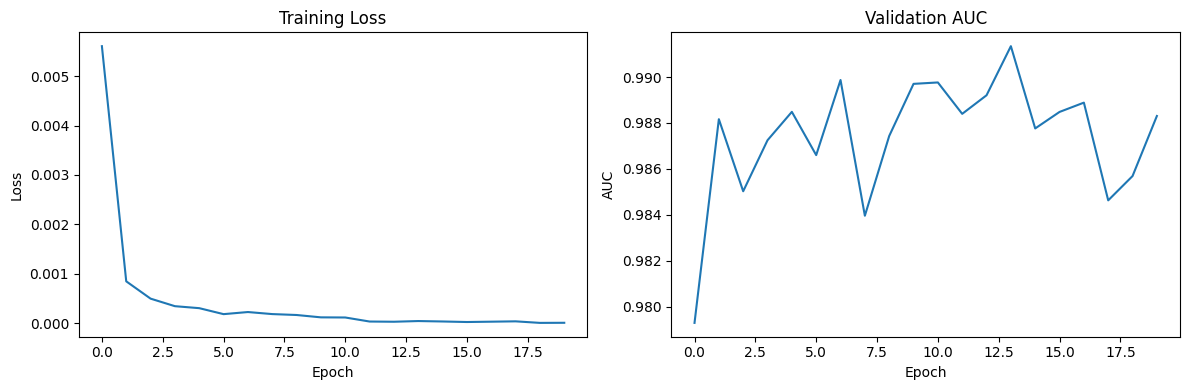

In [9]:
# plot training
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')

axes[1].plot(val_aucs)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('Validation AUC')

plt.tight_layout()
plt.savefig('plots/lstm_training.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Extract Embeddings

In [10]:
model.load_state_dict(torch.load('../models/lstm.pt'))
model.eval()

def extract_embeddings(loader):
    embeddings = []
    probs = []
    indices = []
    labels = []

    with torch.no_grad():
        for batch_x, batch_y, batch_idx in loader:
            batch_x = batch_x.to(device)
            logits, emb = model(batch_x, return_embedding=True)

            embeddings.append(emb.cpu().numpy())
            probs.append(torch.sigmoid(logits).cpu().numpy())
            indices.extend(batch_idx.numpy())
            labels.extend(batch_y.numpy().flatten())

    return {
        'embeddings': np.vstack(embeddings),
        'probs': np.vstack(probs).flatten(),
        'indices': np.array(indices),
        'labels': np.array(labels)
    }

print("Extracting embeddings...")
train_emb = extract_embeddings(train_loader)
test_emb = extract_embeddings(test_loader)

print(f"Train embeddings: {train_emb['embeddings'].shape}")
print(f"Test embeddings: {test_emb['embeddings'].shape}")

Extracting embeddings...
Train embeddings: (800000, 64)
Test embeddings: (200000, 64)


## 8. Create Enhanced Features

In [11]:
X_train_orig = processed_data['X_train']
X_test_orig = processed_data['X_test']

# align embeddings
train_emb_aligned = np.zeros((len(X_train_orig), EMBEDDING_DIM))
for i, idx in enumerate(train_emb['indices']):
    if idx < len(train_emb_aligned):
        train_emb_aligned[idx] = train_emb['embeddings'][i]

test_emb_aligned = np.zeros((len(X_test_orig), EMBEDDING_DIM))
for i, idx in enumerate(test_emb['indices']):
    if idx < len(test_emb_aligned):
        test_emb_aligned[idx] = test_emb['embeddings'][i]

# combine
X_train_enhanced = np.hstack([X_train_orig, train_emb_aligned])
X_test_enhanced = np.hstack([X_test_orig, test_emb_aligned])

lstm_cols = [f'lstm_emb_{i}' for i in range(EMBEDDING_DIM)]
all_feature_names = feature_names + lstm_cols

print(f"Original features: {len(feature_names)}")
print(f"LSTM embeddings: {EMBEDDING_DIM}")
print(f"Enhanced features: {len(all_feature_names)}")

Original features: 61
LSTM embeddings: 64
Enhanced features: 125


In [12]:
# save
enhanced_data = {
    'X_train': X_train_enhanced,
    'X_test': X_test_enhanced,
    'y_train': processed_data['y_train'],
    'y_test': processed_data['y_test'],
    'feature_names': all_feature_names,
    'lstm_embedding_cols': lstm_cols,
    'scaler': processed_data['scaler'],
    'train_customer_ids': processed_data['train_customer_ids'],
    'test_customer_ids': processed_data['test_customer_ids'],
    'scale_pos_weight': (len(processed_data['y_train']) - processed_data['y_train'].sum()) / processed_data['y_train'].sum()
}

with open('../data/processed_data_lstm.pkl', 'wb') as f:
    pickle.dump(enhanced_data, f)

# save predictions
lstm_preds = {
    'train_probs': train_emb['probs'],
    'train_indices': train_emb['indices'],
    'test_probs': test_emb['probs'],
    'test_indices': test_emb['indices']
}

with open('../models/lstm_predictions.pkl', 'wb') as f:
    pickle.dump(lstm_preds, f)

print("Saved enhanced data!")

Saved enhanced data!


## Summary

- LSTM trained on customer transaction sequences
- Best AUC: ~0.99
- Extracted 64-dimensional embeddings
- Enhanced features: 61 original + 64 LSTM = 125 total
